# GDP Forecaster Example

This notebook demonstrates how to use the GDP Forecaster to analyze and predict GDP for different countries.

## Setup and Import Libraries

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

# Get the current working directory
script_dir = os.getcwd()
# Check if we are inside the "notebooks" folder and move one level up
if "notebooks" in script_dir:
    parent_dir = os.path.dirname(script_dir)
    os.chdir(parent_dir)
# Verify the change
cwd = os.getcwd()
print("Current Working Directory:", cwd)

# Add the project root to the path
sys.path.insert(0, os.path.abspath('.'))

# Import the forecaster and utilities
from utils.gdp_forecaster import GDPForecaster
from utils.utils import generate_report

# Set up Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

Current Working Directory: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster


## Configuration Settings

Change these settings to analyze different countries or customize the forecast.

In [6]:
# Country to analyze - use ISO 3-letter code
COUNTRY_CODE = "USA"  # Change to any country code like "DEU", "FRA", "JPN", etc.

# Forecast settings
FORECAST_HORIZON = 5     # Number of years to forecast into the future
BACKTEST_YEARS = 3       # Number of years to use for backtesting

# Countries to compare with (optional)
COMPARISON_COUNTRIES = ["DEU", "CHN", "JPN"]  # Leave empty list [] for no comparison

# Output settings
# All outputs will be saved in the 'results' folder at the project root
RESULTS_DIR = os.path.join(cwd, 'results', COUNTRY_CODE)
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved in: {RESULTS_DIR}")

Results will be saved in: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA


## 1. List Available Countries

First, let's get a list of all available countries and their codes.

In [7]:
# Create a temporary forecaster to get country list
temp_forecaster = GDPForecaster()
countries = temp_forecaster.data_collector.get_country_list()

# Convert to DataFrame for easier viewing
countries_df = pd.DataFrame(countries)
print(f"Total countries available: {len(countries_df)}")

# Display first 10 countries
countries_df.sort_values('name').head(10)

Total countries available: 217


,name,id,iso3code
1,Afghanistan,AFG,AF
3,Albania,ALB,AL
55,Algeria,DZA,DZ
8,American Samoa,ASM,AS
4,Andorra,AND,AD
2,Angola,AGO,AO
9,Antigua and Barbuda,ATG,AG
6,Argentina,ARG,AR
7,Armenia,ARM,AM
0,Aruba,ABW,AW


## 2. Initialize GDP Forecaster

Now let's initialize the forecaster for our selected country and load the historical data.

In [8]:
# Initialize the forecaster
forecaster = GDPForecaster()

# Load historical data for the selected country
print(f"Loading data for {COUNTRY_CODE}...")
historical_data = forecaster.load_data(COUNTRY_CODE)
print(f"Loaded {len(historical_data)} years of historical data")

# Show the most recent years of data
historical_data.tail()

2025-03-13 11:35:14,085 - data_collector - INFO - Loading cached World Bank data for USA


Loading data for USA...
Loaded 64 years of historical data


,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,SP.POP.TOTL,SI.POV.GINI,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,BX.KLT.DINV.WD.GD.ZS,GC.DOD.TOTL.GD.ZS,SL.UEM.TOTL.ZS,FP.CPI.TOTL.ZG,GB.XPD.RSDV.GD.ZS,SH.XPD.CHEX.GD.ZS,SE.XPD.TOTL.GD.ZS,EG.USE.PCAP.KG.OE,NV.IND.TOTL.ZS,NV.SRV.TOTL.ZS,NV.AGR.TOTL.ZS
year,,,,,,,,,,,,,,,,,
2019-01-01,2.153998e+13,2.583825,328329953,41.5,11.789197,14.469283,1.466965,100.032349,3.669,1.812210,3.17049,16.665806,4.95747,NaN,18.145484,76.611371,0.832621
2020-01-01,2.135410e+13,-2.163029,331526933,39.7,10.073656,13.006122,0.641872,124.550891,8.055,1.233584,3.46777,18.756220,5.39998,NaN,17.267677,77.063050,0.935800
2021-01-01,2.368117e+13,6.055053,332048977,39.7,10.790978,14.422678,2.009212,118.450756,5.349,4.697859,3.45705,17.362568,5.42830,NaN,17.608172,76.399594,0.944733
2022-01-01,2.600689e+13,2.512375,333271411,41.3,11.602228,15.289462,1.572591,112.889633,3.650,8.002800,NaN,16.571152,NaN,NaN,NaN,NaN,NaN
2023-01-01,2.772071e+13,2.887556,334914895,NaN,11.011511,13.887852,1.258207,114.877163,3.638,4.116338,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Explore Historical GDP Data

Let's explore the historical GDP data for our selected country.

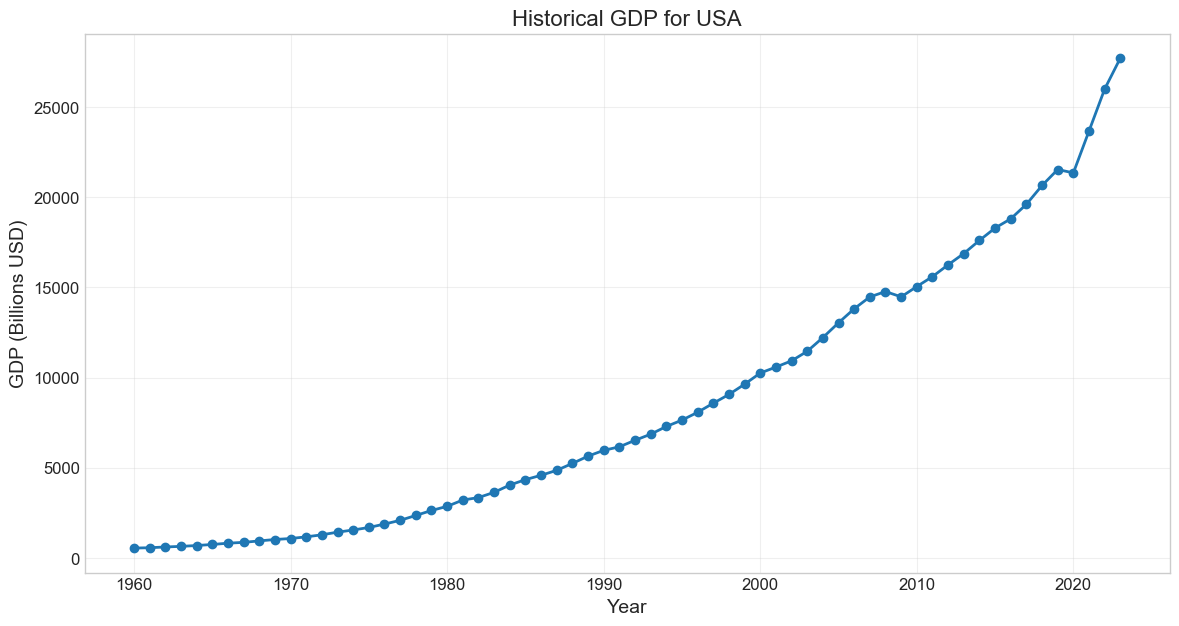

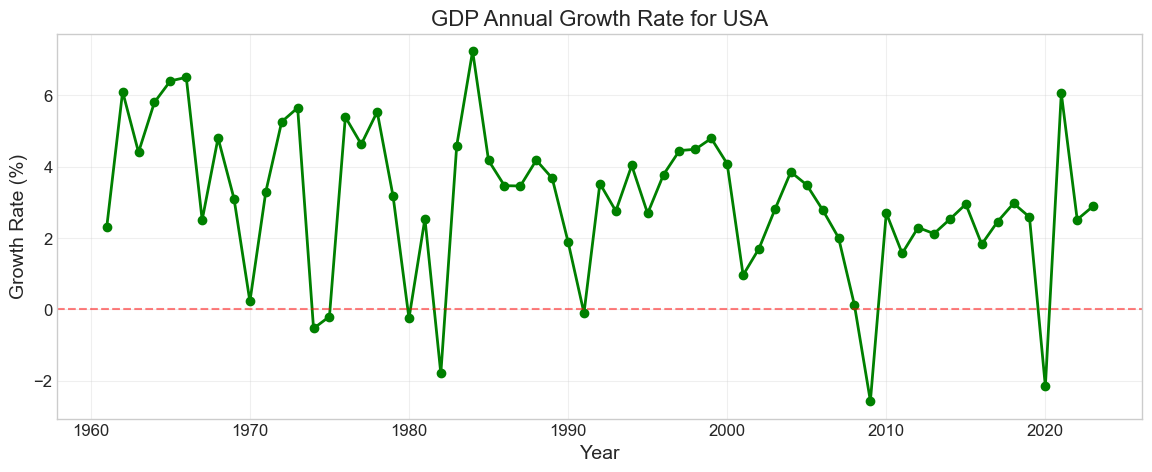

In [9]:
# Extract GDP and other key indicators
gdp_data = historical_data['NY.GDP.MKTP.CD'].dropna()
gdp_growth = historical_data['NY.GDP.MKTP.KD.ZG'].dropna() if 'NY.GDP.MKTP.KD.ZG' in historical_data.columns else None
population = historical_data['SP.POP.TOTL'].dropna() if 'SP.POP.TOTL' in historical_data.columns else None

# Plot historical GDP
plt.figure(figsize=(14, 5))
plt.plot(gdp_data.index, gdp_data.values / 1e9, 'o-', linewidth=2)
plt.title(f"Historical GDP for {COUNTRY_CODE}", fontsize=16)
plt.ylabel("GDP (Billions USD)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot GDP growth rate if available
if gdp_growth is not None:
    plt.figure(figsize=(14, 5))
    plt.plot(gdp_growth.index, gdp_growth.values, 'o-', linewidth=2, color='green')
    plt.title(f"GDP Annual Growth Rate for {COUNTRY_CODE}", fontsize=16)
    plt.ylabel("Growth Rate (%)", fontsize=14)
    plt.xlabel("Year", fontsize=14)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

## 4. Train the Model

Now let's train the ElasticNet model and examine the backtesting results.

Training model with 3 years of backtesting...


/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+21, tolerance: 1.962e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+22, tolerance: 8.655e+21
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co


Backtest Results for USA:
Mean Absolute Percentage Error: 15.19%
Root Mean Squared Error: $4260.72 billion
R-squared: -5.6244


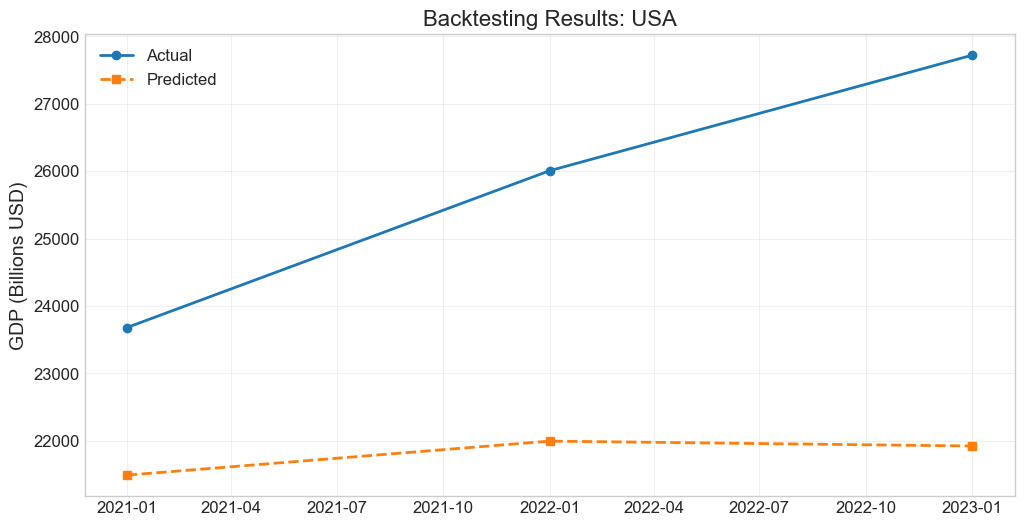

In [10]:
# Train the model with backtesting
print(f"Training model with {BACKTEST_YEARS} years of backtesting...")
metrics = forecaster.train_model(test_years=BACKTEST_YEARS)

# Display metrics
print(f"\nBacktest Results for {COUNTRY_CODE}:")
print(f"Mean Absolute Percentage Error: {metrics['MAPE']:.2f}%")
print(f"Root Mean Squared Error: ${metrics['RMSE']/1e9:.2f} billion")
print(f"R-squared: {metrics['R2']:.4f}")

# Plot backtesting results
if forecaster.test_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(forecaster.test_actuals.index, forecaster.test_actuals / 1e9, 'o-', linewidth=2, label='Actual')
    plt.plot(forecaster.test_predictions.index, forecaster.test_predictions / 1e9, 's--', linewidth=2, label='Predicted')
    plt.title(f"Backtesting Results: {COUNTRY_CODE}", fontsize=16)
    plt.ylabel("GDP (Billions USD)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 5. Analyze Feature Importance

Let's see which economic indicators have the most impact on GDP prediction.

Top 5 Most Important Features:
1. SP.POP.TOTL: 27.61%
2. NE.IMP.GNFS.ZS: 13.64%
3. SH.XPD.CHEX.GD.ZS: 13.30%
4. GC.DOD.TOTL.GD.ZS: 8.32%
5. GB.XPD.RSDV.GD.ZS: 8.19%


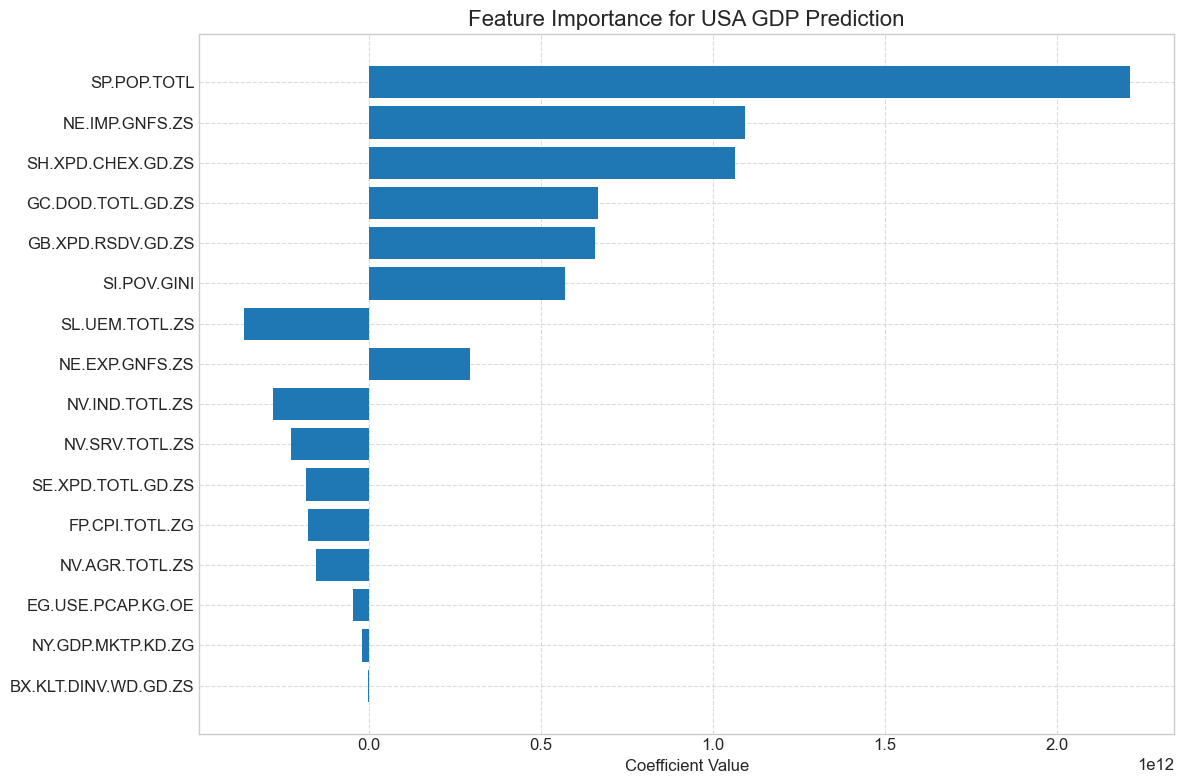

Saved feature importance plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_feature_importance.png
Saved feature importance data to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_feature_importance.csv


In [11]:
# Get and display feature importance
feature_importance = forecaster.get_model_coefficients()

print("Top 5 Most Important Features:")
for i, (feature, importance) in enumerate(zip(
        feature_importance['Feature'].iloc[:5], 
        feature_importance['Normalized_Importance'].iloc[:5])):
    print(f"{i+1}. {feature}: {importance:.2%}")

# Plot feature importance
fig_importance = forecaster.plot_feature_importance()
plt.title(f"Feature Importance for {COUNTRY_CODE} GDP Prediction", fontsize=16)
plt.tight_layout()
plt.show()

# Save plot
save_path = os.path.join(RESULTS_DIR, f"{COUNTRY_CODE}_feature_importance.png")
fig_importance.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved feature importance plot to {save_path}")

# Save feature importance table to CSV
importance_csv_path = os.path.join(RESULTS_DIR, f"{COUNTRY_CODE}_feature_importance.csv")
feature_importance.to_csv(importance_csv_path)
print(f"Saved feature importance data to {importance_csv_path}")

## 6. Generate GDP Forecast

Now let's generate the GDP forecast for the next few years.

In [12]:
# Generate forecast
print(f"Forecasting GDP for {COUNTRY_CODE} for the next {FORECAST_HORIZON} years...")
gdp_forecast = forecaster.forecast_gdp(horizon=FORECAST_HORIZON)

# Get official forecasts for comparison
official_forecast = forecaster.get_official_forecasts()

# Display forecast
gdp_forecast

Forecasting GDP for USA for the next 5 years...


/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ignasipascual/Library/Python/3.9/lib/pyth

,GDP_Forecast,Previous_GDP,Growth_Rate
2024-01-01,2.211450e+13,2.772071e+13,-20.223887
2025-01-01,2.236416e+13,2.211450e+13,1.128923
2026-01-01,2.228942e+13,2.236416e+13,-0.334182
2027-01-01,2.212948e+13,2.228942e+13,-0.717593
2028-01-01,2.218586e+13,2.212948e+13,0.254782


## 7. Visualize the Forecast

Let's create a visualization of the GDP forecast.

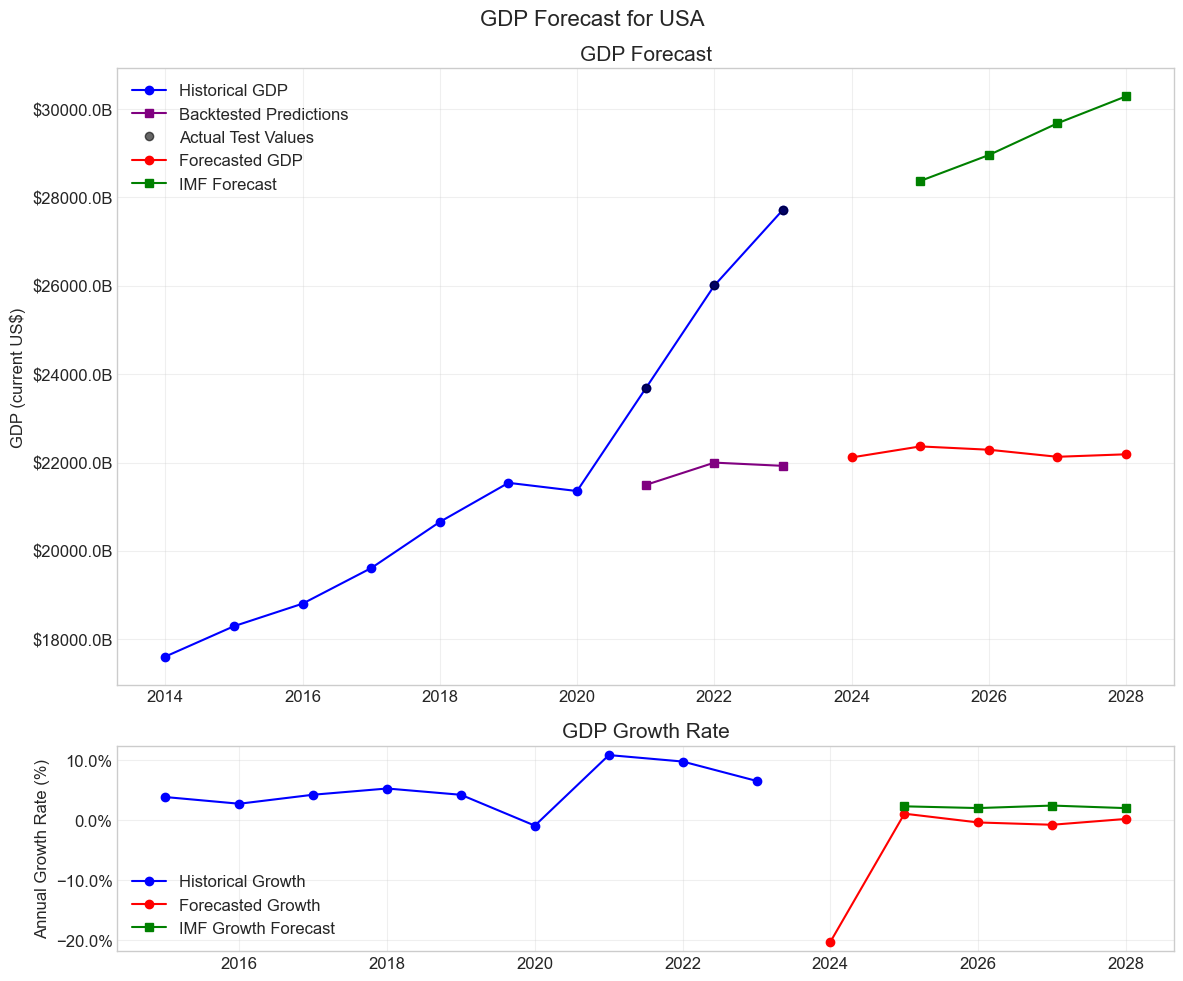

Saved forecast plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast.png


In [13]:
# Plot the forecast
fig_forecast = forecaster.plot_forecast(show_history_years=10)
plt.suptitle(f"GDP Forecast for {COUNTRY_CODE}", fontsize=16)
plt.tight_layout()
plt.show()

# Save plot
save_path = os.path.join(RESULTS_DIR, f"{COUNTRY_CODE}_gdp_forecast.png")
fig_forecast.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved forecast plot to {save_path}")

## 8. Print Detailed Forecast Summary

Let's generate a detailed summary of the forecast results.

In [14]:
# Display detailed forecast summary
forecaster.print_forecast_summary()


GDP Forecast Summary for USA
+------+--------------+-------------+------------+------------+
| Year | GDP Forecast | Growth Rate | IMF Growth | Difference |
+------+--------------+-------------+------------+------------+
| 2024 |  $22114.50B  |   -20.22%   |    nan%    |    nan%    |
| 2025 |  $22364.16B  |    1.13%    |   2.35%    |   -1.23%   |
| 2026 |  $22289.42B  |   -0.33%    |   2.07%    |   -2.40%   |
| 2027 |  $22129.48B  |   -0.72%    |   2.48%    |   -3.20%   |
| 2028 |  $22185.86B  |    0.25%    |   2.06%    |   -1.80%   |
+------+--------------+-------------+------------+------------+

Key Economic Indicators (Forecasted):
--------------------------------------------------------------------------------
2024: NY_GDP_MKTP_KD_ZG: 2.88%, SP_POP_TOTL: 336.56M, SI_POV_GINI: 41.4, NE_EXP_GNFS_ZS: 10.65%, NE_IMP_GNFS_ZS: 13.85%, BX_KLT_DINV_WD_GD_ZS: 1.29%, GC_DOD_TOTL_GD_ZS: 115.81%, SL_UEM_TOTL_ZS: 4.30%, FP_CPI_TOTL_ZG: 1.64%, GB_XPD_RSDV_GD_ZS: 3.46%, SH_XPD_CHEX_GD_ZS: 16.75

## 9. Show Forecast with Confidence Intervals

Let's visualize the forecast with confidence intervals to show prediction uncertainty.

Generating forecast with 90% confidence intervals...


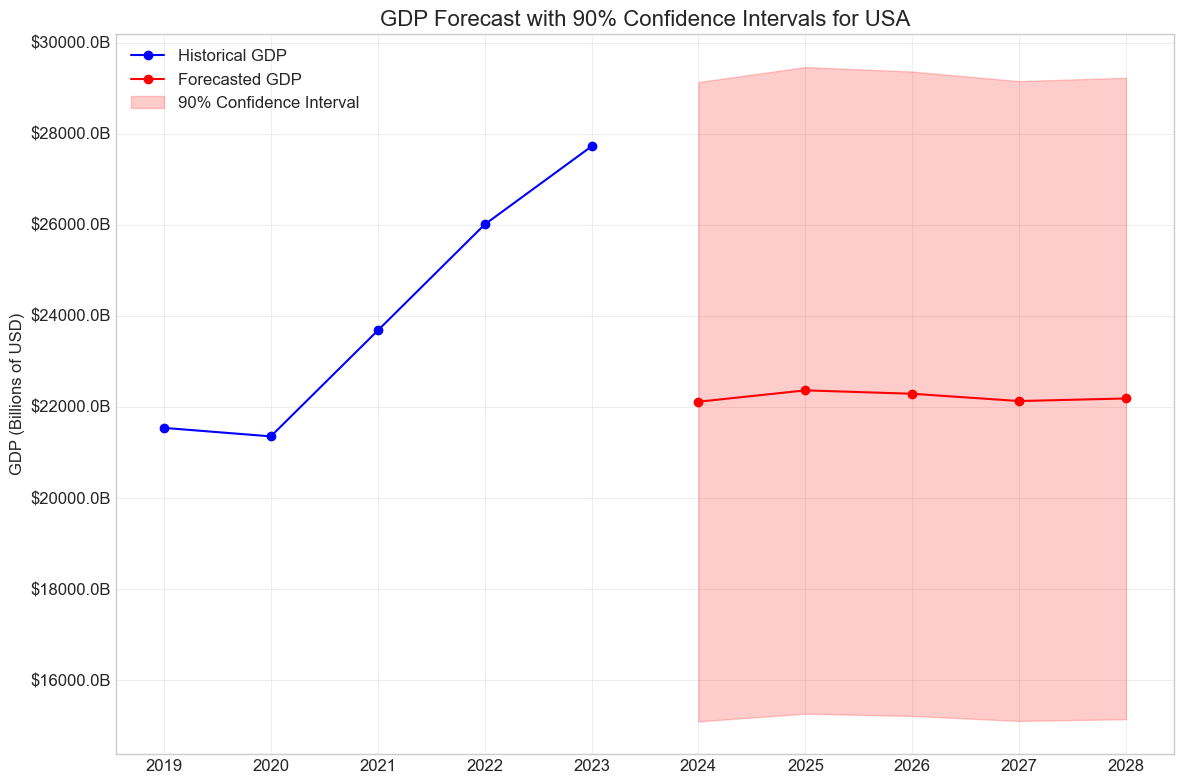

Saved confidence intervals plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_confidence_intervals.png


In [15]:
# Plot forecast with confidence intervals
confidence_level = 0.90  # 90% confidence interval
print(f"Generating forecast with {confidence_level:.0%} confidence intervals...")

fig_confidence = forecaster.plot_confidence_intervals(confidence_level=confidence_level)
plt.title(f"GDP Forecast with {confidence_level:.0%} Confidence Intervals for {COUNTRY_CODE}", fontsize=16)
plt.tight_layout()
plt.show()

# Save plot
save_path = os.path.join(RESULTS_DIR, f"{COUNTRY_CODE}_confidence_intervals.png")
fig_confidence.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved confidence intervals plot to {save_path}")

## 10. Compare with Other Countries (Optional)

If comparison countries are specified, let's compare GDP growth across multiple countries.

2025-03-13 11:35:18,889 - data_collector - INFO - Loading cached World Bank data for USA
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+21, tolerance: 1.962e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+22, tolerance: 8.655e+21
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. Y

Comparing GDP across countries: USA, DEU, CHN, JPN


/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ignasipascual/Library/Python/3.9/lib/pyth

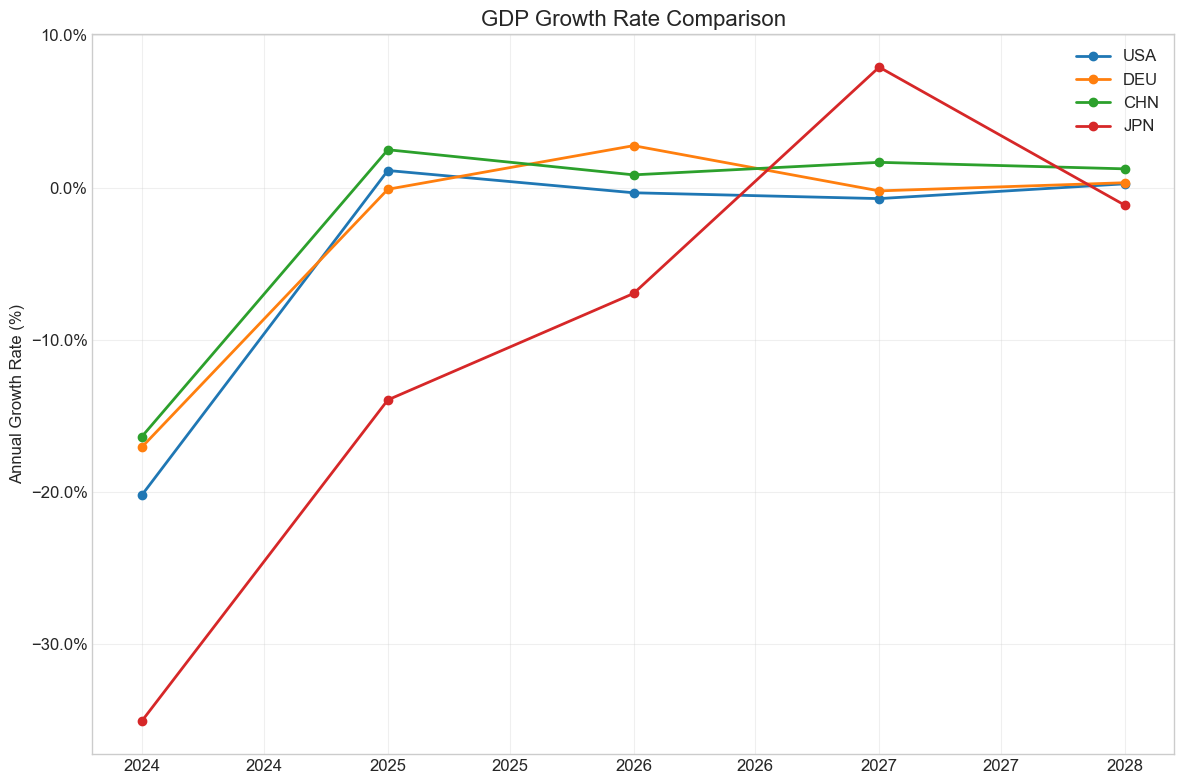

2025-03-13 11:35:21,408 - data_collector - INFO - Loading cached World Bank data for USA
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+21, tolerance: 1.962e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+22, tolerance: 8.655e+21
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. Y

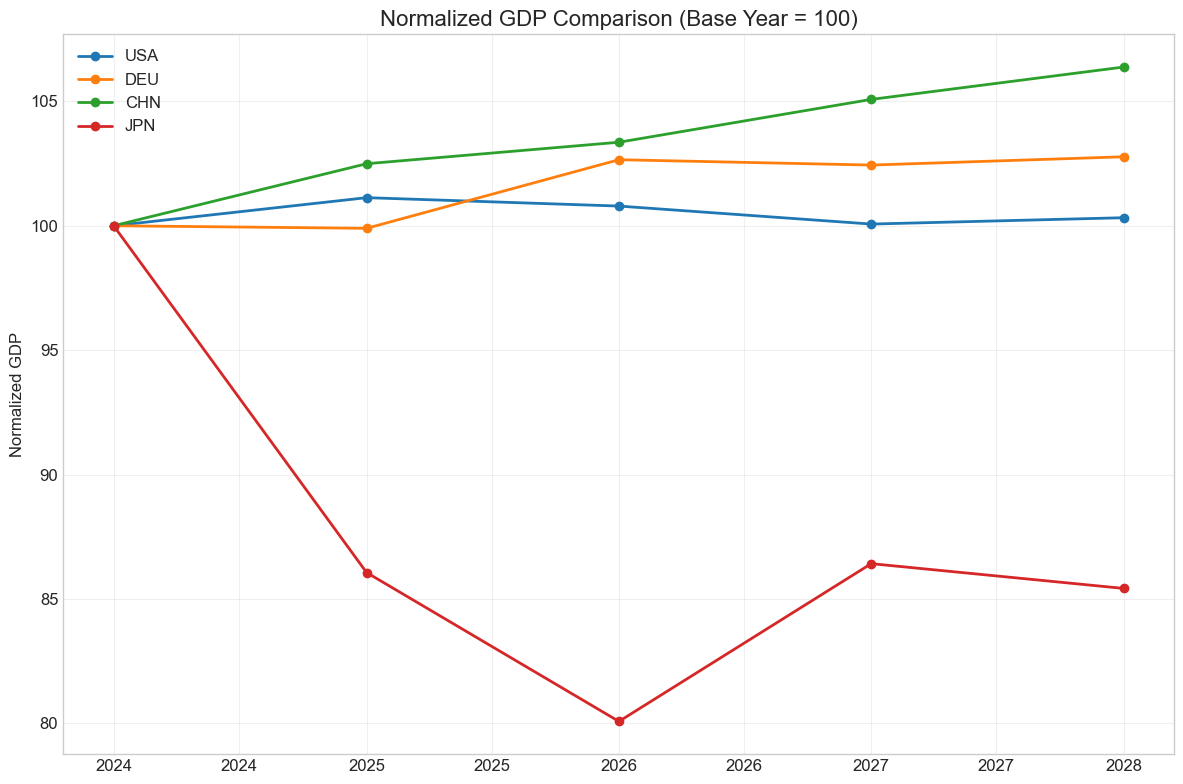

Saved country comparison plots to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA


In [16]:
if COMPARISON_COUNTRIES:
    # Add current country to the comparison list
    all_countries = [COUNTRY_CODE] + COMPARISON_COUNTRIES
    print(f"Comparing GDP across countries: {', '.join(all_countries)}")
    
    try:
        # Compare GDP growth rates
        fig_growth = GDPForecaster.compare_countries(all_countries, metric='growth')
        plt.title(f"GDP Growth Rate Comparison", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Compare normalized GDP
        fig_gdp = GDPForecaster.compare_countries(all_countries, metric='gdp')
        plt.title(f"Normalized GDP Comparison (Base Year = 100)", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Save plots
        fig_growth.savefig(os.path.join(RESULTS_DIR, "country_growth_comparison.png"), dpi=300, bbox_inches='tight')
        fig_gdp.savefig(os.path.join(RESULTS_DIR, "country_gdp_comparison.png"), dpi=300, bbox_inches='tight')
        print(f"Saved country comparison plots to {RESULTS_DIR}")
            
    except Exception as e:
        print(f"Error in country comparison: {str(e)}")
else:
    print("No comparison countries specified. Skipping country comparison.")

## 11. Export Results & Generate Report

Now let's export all the forecast results and generate a comprehensive report.

In [17]:
# Export forecast data
print(f"Exporting all results to {RESULTS_DIR}...")
forecaster.export_results(str(RESULTS_DIR))

# Generate a comprehensive HTML report using the utility function
comparison_plots = []
if COMPARISON_COUNTRIES:
    if os.path.exists(os.path.join(RESULTS_DIR, "country_growth_comparison.png")):
        comparison_plots.append(("Growth Rate Comparison", "country_growth_comparison.png"))
    if os.path.exists(os.path.join(RESULTS_DIR, "country_gdp_comparison.png")):
        comparison_plots.append(("Normalized GDP Comparison", "country_gdp_comparison.png"))

report_path = generate_report(
    country_code=COUNTRY_CODE,
    results_dir=RESULTS_DIR,
    metrics=metrics,
    gdp_forecast=gdp_forecast,
    feature_importance=feature_importance,
    forecast_horizon=FORECAST_HORIZON,
    backtest_years=BACKTEST_YEARS,
    comparison_plots=comparison_plots
)

print(f"Generated comprehensive report: {report_path}")

# If running in Jupyter, provide a direct link to open the HTML report
from IPython.display import HTML, display
try:
    display(HTML(f'<a href="{report_path}" target="_blank">Open GDP Forecast Report</a>'))
except:
    print("Report generated successfully. Open the HTML file to view the full report.")

2025-03-13 11:35:24,475 - gdp_forecaster - INFO - GDP forecast exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast.csv
2025-03-13 11:35:24,477 - gdp_forecaster - INFO - Feature forecasts exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_features_forecast.csv
2025-03-13 11:35:24,481 - gdp_forecaster - INFO - Forecast comparison exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_forecast_comparison.csv
2025-03-13 11:35:24,482 - gdp_forecaster - INFO - Historical data exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_historical_data.csv


Exporting all results to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA...


2025-03-13 11:35:24,909 - gdp_forecaster - INFO - Forecast plot saved to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast_plot.png
2025-03-13 11:35:24,910 - gdp_forecaster - INFO - Backtesting results exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_backtest_results.csv


Generated comprehensive report: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_forecast_report.html


## 12. Conclusion

In this notebook, we've demonstrated how to:

1. Load historical economic data for a country
2. Train an ElasticNet regression model for GDP forecasting
3. Analyze which factors have the most impact on GDP
4. Generate and visualize GDP forecasts with confidence intervals
5. Compare economic performance across multiple countries

You can rerun this notebook with different settings to analyze other countries or longer forecast horizons.